# Main Aggregation Script - calls lab.py and crystals.py

In [35]:
#Reloads the lab.py and crystals.py modules to update any changes (after saving)
#If a new method or object is created, autoreload doesn't work and the 
#kernel needs to be closed and halted after saving and making a 'checkpoint'
#in this notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import ipas 
import numpy as np
import dask
from dask_jobqueue import SLURMCluster
from distributed import LocalCluster
from dask.distributed import Client, progress
from dask import delayed
from dask import dataframe as dd
import functools
import sys
import ast
from struct import *
import pickle
import glob
import random
import pandas as pd
import time
from dask.distributed import as_completed
from joblib import Parallel, delayed, parallel_backend
import matplotlib.pyplot as plt

In [38]:
cluster = SLURMCluster(
    queue='kratos',
    walltime='04-23:00:00',
    cores=1,
    memory='20000MiB', #1 GiB = 1,024 MiB
    processes=1)

#cluster.adapt(minimum=3, maximum=20)
cluster.scale(10)

/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [39]:
client = Client(cluster)

In [42]:
client

Client Scheduler: tcp://169.226.65.50:37115 Dashboard: http://169.226.65.50:44333/status,Cluster Workers: 10 Cores: 10 Memory: 209.70 GB


# Initialize databases for queries

In [159]:
files = ['sqlite:///'+f for f in glob.glob("db_files/IPAS_*_lastmono.sqlite")]
tables = ['aggregates', 'crystals']

In [160]:
%%time

df=[]
for table in tables:
    
    #read tables in parallel on client 
    read_files = [dask.delayed(dd.read_sql_table)(table=table, uri=file, index_col='id') for file in files]
    
    compute_read = client.compute(read_files)
    print('done with compute')
    ddfs = client.gather(compute_read)
    print('done with gather')
    #concatenate all sqlite files vertically (axis=0 default) (same columns)
    gathered_reads = client.scatter(ddfs)
    ddf = client.submit(dd.concat, gathered_reads).result()
    print('done with submit')
    #append combined dask df for each table
    df.append(ddf)


done with compute
done with gather
done with submit
done with compute
done with gather
done with submit
CPU times: user 7.48 s, sys: 509 ms, total: 7.99 s
Wall time: 55.5 s


In [161]:
%time df_concat = dd.concat([df[0], df[1]], axis=1)

CPU times: user 6.06 ms, sys: 1.04 ms, total: 7.1 ms
Wall time: 7.32 ms


/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/dask/dataframe/multi.py:1055: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  "Concatenating dataframes with unknown divisions.\n"


In [162]:
df_concat.agg_r = np.power((np.power(df_concat.a, 2) * df_concat.c), (1./3.))

In [163]:
def query_r_5000(df):
    return df[df.agg_r < 5000]

df_concat = df_concat.map_partitions(query_r_5000)
#len(df_concat) #86% of dataset

In [164]:
df_repart = df_concat.repartition(partition_size="100MB").persist()
df_repart.npartitions

50

# MAIN

In [165]:
def main():
    
    output = np.empty((mono_phi_bins,mono_r_bins),dtype=object)
    hold_monos1 = np.empty((mono_phi_bins,mono_r_bins,nclusters), dtype=object)
    hold_monos2 = np.empty((mono_phi_bins,mono_r_bins,nclusters), dtype=object)
    
    for j in range(mono_phi_bins): 
        for k in range(mono_r_bins):   
            print('phio, r', phio_m[j],req_m[k])
            
            df_mono = df[1][(df[1].phi < phio_m[j]+(phio_m[j]*0.01)) &\
                            (df[1].phi > phio_m[j]-(phio_m[j]*0.01)) &\
                            (df[1].r < req_m[k]+(req_m[k]*0.01)) &\
                            (df[1].r > req_m[k]-(req_m[k]*0.01))].compute()

            samples_mono = df_mono.sample(nclusters)
            
            n_monos=0
            for mono in samples_mono.itertuples():
                mono = ipas.IceCrystal(mono)
                
                hold_monos1[j,k,n_monos] = mono
                n_monos+=1
                
            samples_mono = df_mono.sample(nclusters)
            
            n_monos=0
            for mono in samples_mono.itertuples():
                mono = ipas.IceCrystal(mono)
                
                hold_monos2[j,k,n_monos] = mono
                n_monos+=1
      
            ipas.collect_clusters(hold_monos1[j,k,:], hold_monos2[j,k,:], rand_orient=rand_orient)
            #output[j,k] = dask.delayed(ipas.collect_clusters)(hold_monos1[j,k,:],\
            #                                                      hold_monos2[j,k,:], rand_orient=rand_orient)
    
    return output
    

In [166]:
def compute():
    results = np.empty((mono_phi_bins, mono_r_bins, nclusters))
    rxs = np.empty((mono_phi_bins, mono_r_bins, nclusters))
    rys = np.empty((mono_phi_bins, mono_r_bins, nclusters))
    rzs = np.empty((mono_phi_bins, mono_r_bins, nclusters))
    phi2Ds = np.empty((mono_phi_bins, mono_r_bins, nclusters))
    cplxs = np.empty((mono_phi_bins, mono_r_bins, nclusters))
    dd = np.empty((mono_phi_bins, mono_r_bins, nclusters))

    gather = client.compute([*output.tolist()])  #only parallelizing agg r bins
    gather = client.gather(gather)

    gather = np.array(gather)
    print(np.shape(gather))
    rxs = gather[:,:,0,:]
    rys = gather[:,:,1,:]
    rzs = gather[:,:,2,:]
    phi2Ds = gather[:,:,3,:]
    cplxs = gather[:,:,4,:] 
    dd = gather[:,:,5,:]

    print('DONE!')
    return rxs, rys, rzs, phi2Ds, cplxs, dd

phio, r 0.01 1


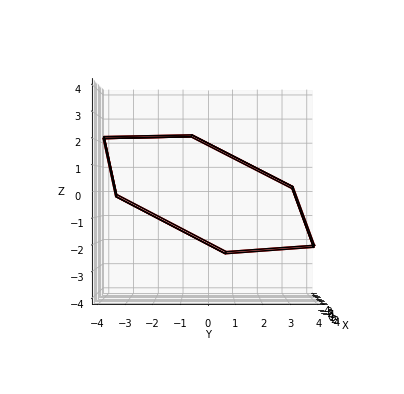

1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.000

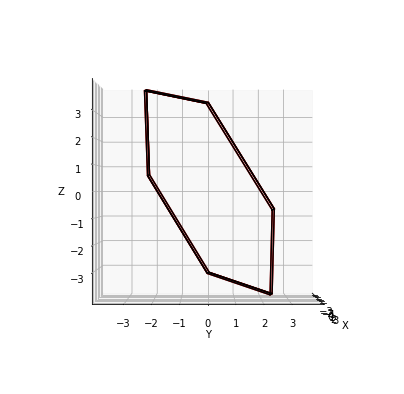

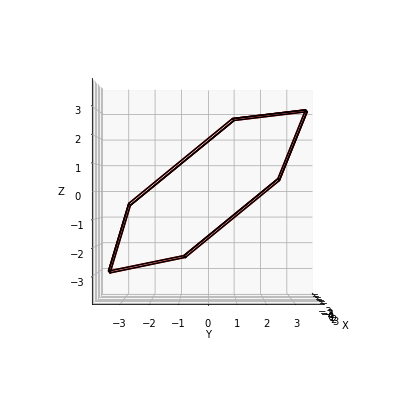

1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.000

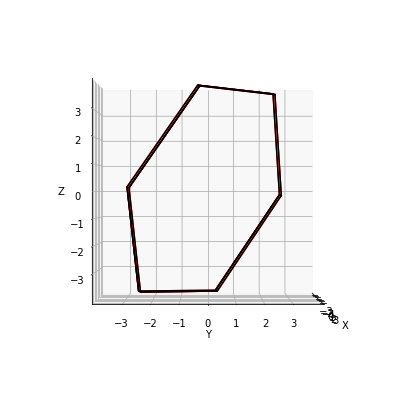

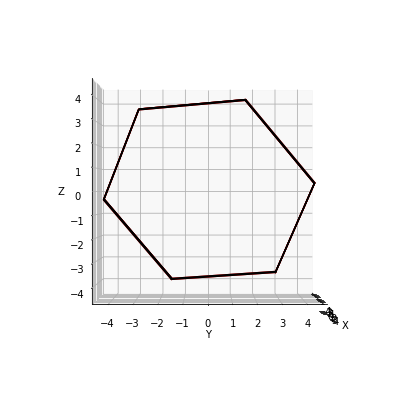

1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.000

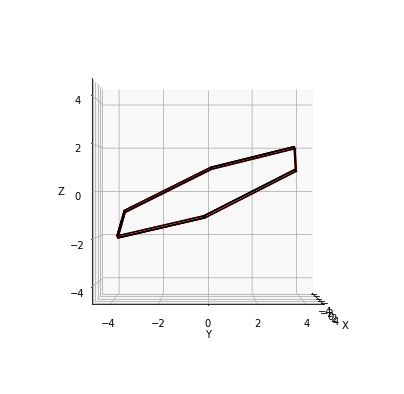

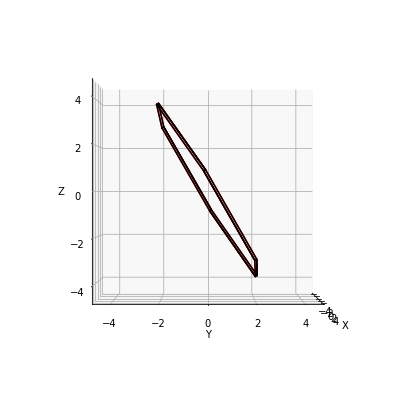

1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.000

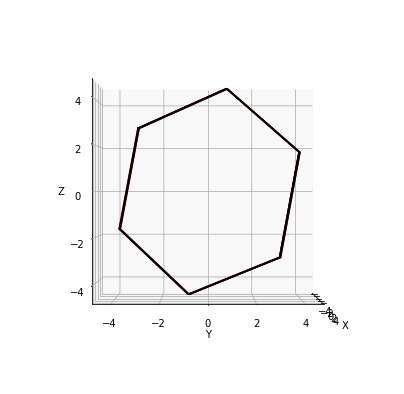

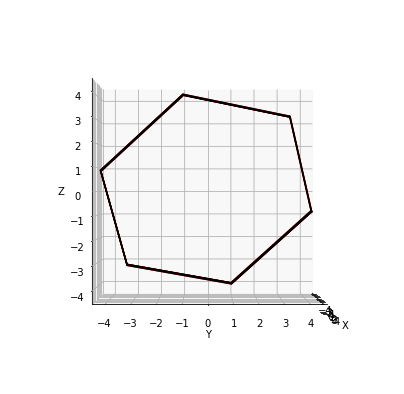

1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.000

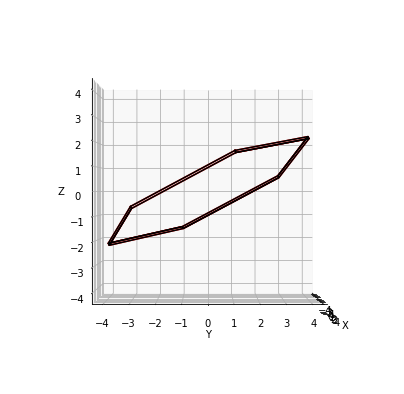

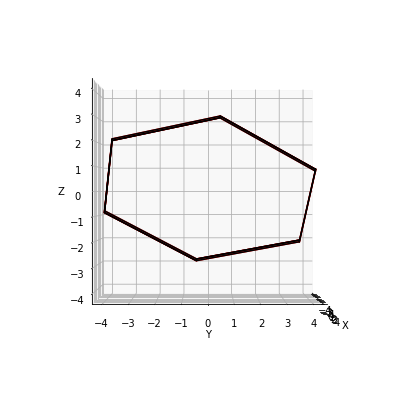

1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.000

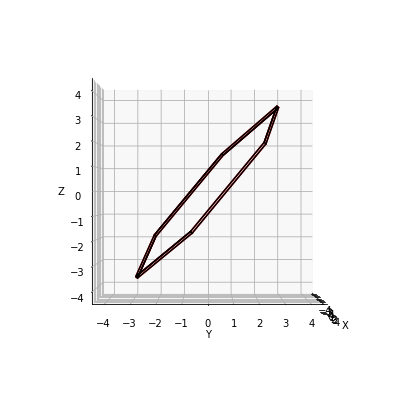

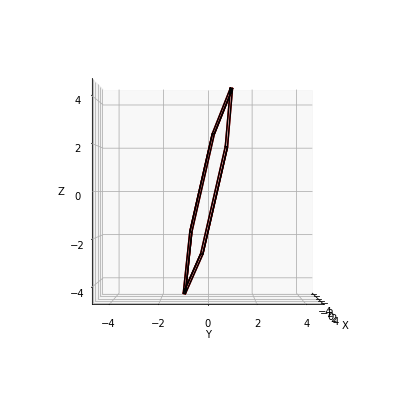

1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.000

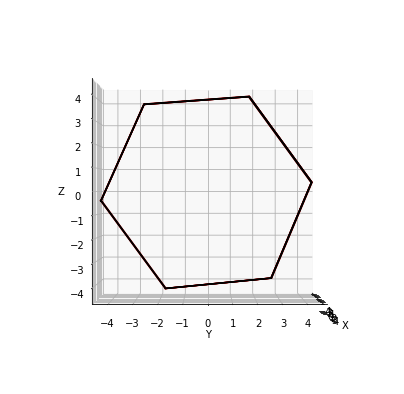

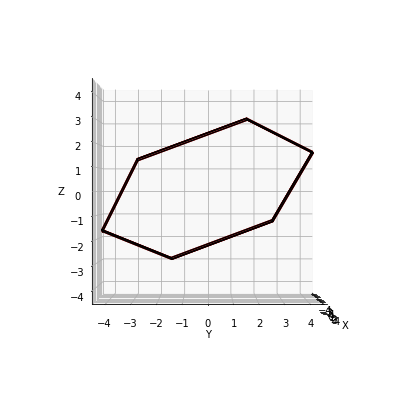

1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.000

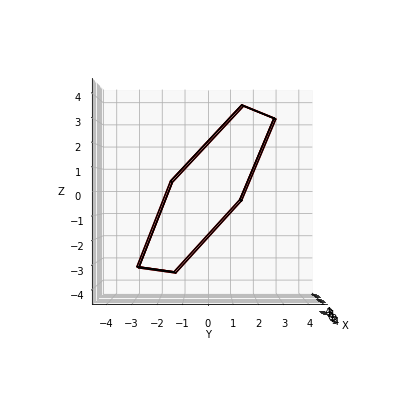

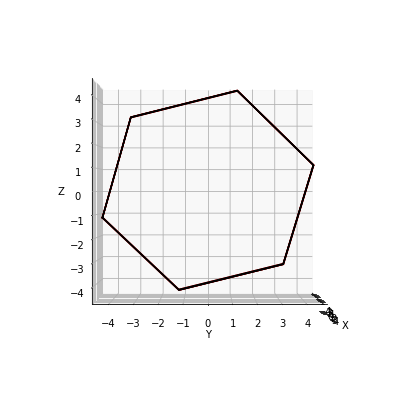

1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.000

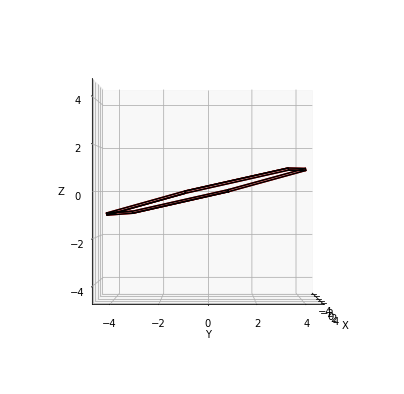

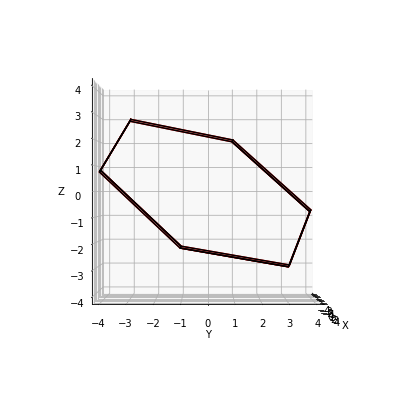

1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.000

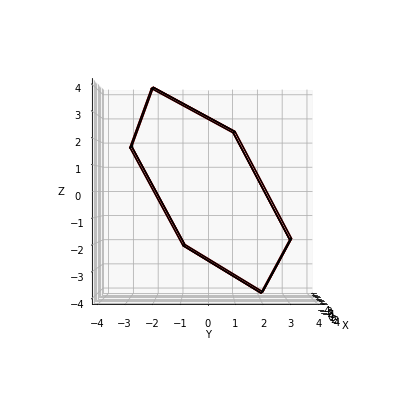

len of data:  0 0
phio, r 0.01 2


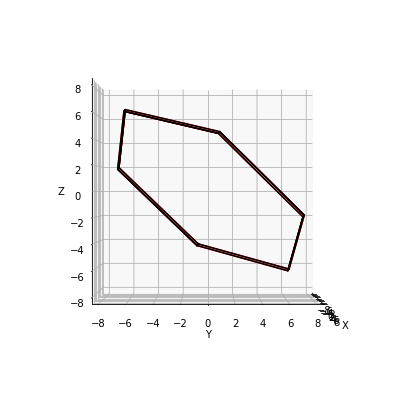

1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.000

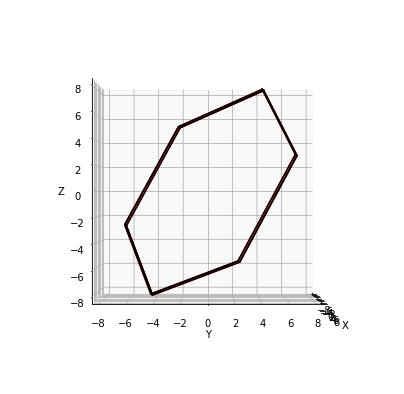

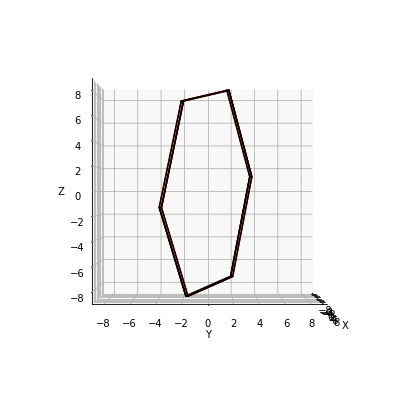

1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.000

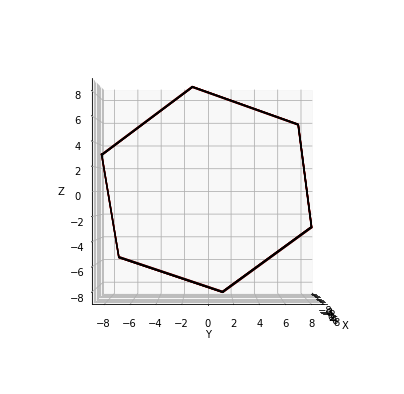

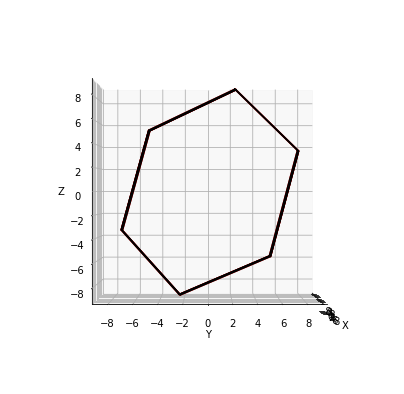

1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.000

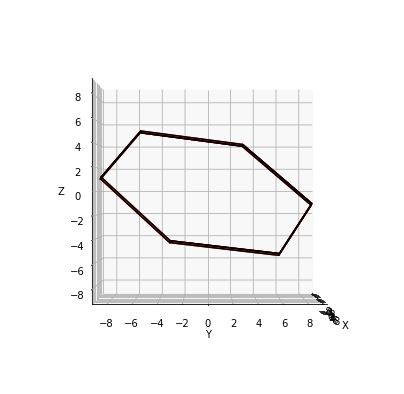

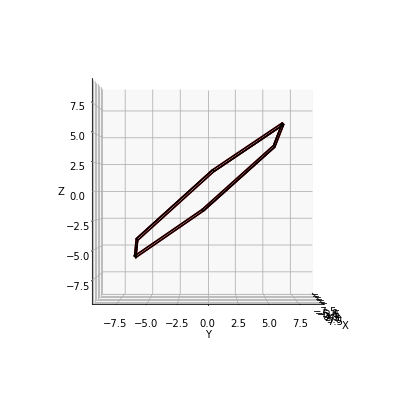

1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.000

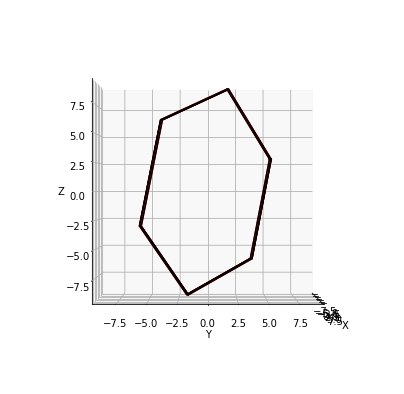

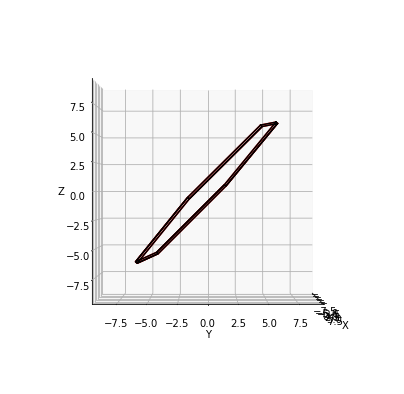

1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
0.9999999999999997 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0 0.0 0.0
------------
1.0000000000000002 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999999 0.0 0.0
------------
0.9999999999999998 0.0 0.0
------------
1.000

KeyboardInterrupt: 

In [186]:
if __name__ == '__main__':
    rand_orient = False      #randomly orient the seed crystal and new crystal: uses first random orientation
    req_m = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]
    mono_phi_bins = 20
    mono_r_bins = len(req_m)
    nclusters = 10
    phio_m=np.logspace(-2, 2, num=mono_phi_bins, dtype=None)#just columns (0,2); plates (-2,0)

    output = main()
    rxs, rys, rzs, phi2Ds, cplxs, dd = compute()
    results = {'rxs': rxs, 'rys':rys, 'rzs':rzs, 'phi2Ds':phi2Ds, \
               'cplxs':cplxs, 'dd':dd}

    
#     filename = 'instance_files/instance_db_iceice_rand'
#     filehandler = open(filename, 'wb')
#     pickle.dump(results, filehandler)
#     filehandler.close()

In [ ]:
file = open('instance_files/instance_db_iceice_flat', 'rb')
b = pickle.load(file)

In [ ]:
#for returning output as an array
nclusters = 300
rxs = np.zeros((20,20,nclusters))
rys = np.zeros((20,20,nclusters))
rzs = np.zeros((20,20,nclusters))
phi2Ds = np.zeros((20,20,nclusters))
cplxs = np.zeros((20,20,nclusters))
dds = np.zeros((20,20,nclusters))
cluster1_ncrystals = np.zeros((20,20,nclusters))
cluster2_ncrystals = np.zeros((20,20,nclusters))
       
for phi in range(20):
    for r in range(20):
        rxs[phi, r, :] = b['rxs'][phi,r,:]
        rys[phi, r, :] = b['rys'][phi,r,:]
        rzs[phi, r, :] = b['rzs'][phi,r,:]
        phi2Ds[phi, r, :] = b['phi2Ds'][phi,r,:]
        cplxs[phi, r, :] = b['cplxs'][phi,r,:]
        dds[phi, r, :] = b['dd'][phi,r,:]
        cluster1_ncrystals[phi, r, :] = b['cluster1_ncrystals'][phi,r,:]
        cluster2_ncrystals[phi, r, :] = b['cluster2_ncrystals'][phi,r,:]

In [ ]:
class IceClusterBatch():
    """A collection of IceCluster objects."""
    
    def __init__(self, nclusters, rxs, rys, rzs, phi2Ds, cplxs, dds, numaspectratios, numrs):

        self.nclusters=nclusters
        self.rxs = rxs
        self.rys = rys
        self.rzs = rzs
        self.phi2Ds = phi2Ds
        self.cplxs = cplxs
        self.dds = dds
        self.numaspectratios = numaspectratios
        self.numrs = numrs


    def calculate_error(self, data, ch):
        mean = np.mean(data)
        std = np.std(data)
        shape = (mean/std)**2
        scale = (std**2)/mean
        shapech = mean/(self.numaspectratios*ch)

        pos_error = mean + std
        neg_error = mean - std

        min_data = min(data)
        max_data = max(data)

        return(pos_error, neg_error, min_data, max_data, mean)        


    def fit_distribution(self, data, normed = True, facecolor='navy', alpha=1.0,**kwargs):

        """Model data by finding best fit distribution to data"""
        # Get histogram of original data

        #fig = plt.figure(figsize=(5,7))
        #ax = plt.subplot(131)

        data = np.array(data)
        data[np.isinf(data)] = min(data)
        data[np.isnan(data)] = min(data)
        if np.isinf(data).any():
            print('inf True')
        y, x = np.histogram(data, density=True)
        #print('x hist',x)
        xx = (x + np.roll(x, -1))[:-1] / 2.0

        
        params = st.gamma.fit(data)
        gamma_params = params
        arg = gamma_params[:-2]
        #fig = plt.figure(figsize=(10,7))
        #ax = fig.add_subplot(111)
        #n, bins, patches = plt.hist(data, bins=bins, normed=True,
        #                            color='navy',range=(min(data), max(data)),**kwargs)
        #pdf = self.make_pdf(distribution, gamma_params)
        pdf = st.gamma.pdf(xx, loc=gamma_params[-2], scale=gamma_params[-1], *arg)
        indmax = np.argmax(pdf)  #FIRST index where the highest prob occurs
        gammach_var = x[indmax] #characteristic of the distribution
        #ax = plt.plot(xx, pdf, lw=5, color='darkorange')
        #plt.show()

        return gammach_var

In [ ]:
#find characteristic of gamma distribution
numaspectratios=len(rxs[:,0,0])
numrs=len(rxs[0,:,0])
batch = IceClusterBatch(nclusters, rxs, rys, rzs, phi2Ds, \
                        cplxs, dds, numaspectratios, numrs)

rxs_ch = np.empty((numaspectratios, numrs), dtype=np.float64)
rzs_ch = np.empty((numaspectratios, numrs), dtype=np.float64)
rzs_mean = np.empty((numaspectratios, numrs), dtype=np.float64)
dds_ch = np.empty((numaspectratios, numrs), dtype=np.float64)

for i in range(numaspectratios):
    for r in range(numrs):
        for c, data in enumerate([rxs, rzs, dds]):
            if c == 0:
                rxs_ch[i,r] = batch.fit_distribution(data[i,r,:])
            if c == 1:
                rzs_ch[i,r] = batch.fit_distribution(data[i,r,:])
                _,_,_,_,rzs_mean[i,r] = batch.calculate_error(data[i,r,:], rzs_ch[i,r])
            if c == 2:
                dds_ch[i,r] = batch.fit_distribution(data[i,r,:])
                

In [ ]:
#write to file for output as array:
with open("lookup_tables/minorax_flat_ch_iceice.dat","wb") as file1:
    with open("lookup_tables/majorax_flat_ch_iceice.dat","wb") as file2:
        with open("lookup_tables/majorax_flat_mean_iceice.dat","wb") as file3:
            with open("lookup_tables/dd_flat_ch_iceice.dat","wb") as file4:
                file1.write('IceAgg collection from the database for the flat orientation. \n')
                file1.write('Characteristic values taken from the peak of a fitted \n'\
                            'gamma distribution from 300 aggregates.\n)
                file2.write('IceAgg collection from the database for the flat orientation. \n')
                file2.write('Characteristic values taken from the peak of a fitted \n'\
                            'gamma distribution from 300 aggregates.\n)
                file3.write('IceAgg collection from the database for the flat orientation. \n')
                file3.write('Characteristic values taken from the peak of a fitted \n'\
                            'gamma distribution from 300 aggregates.\n)
                file4.write('IceAgg collection from the database for the flat orientation. \n')
                file4.write('Characteristic values taken from the peak of a fitted \n'\
                            'gamma distribution from 300 aggregates.\n)
                
                            
                for i in range(mono_phi_bins):
                    for r in range(mono_r_bins):
                        #print(i,r)
                        #print(all_r_bins[i,r], all_r_bins[i,r+1])
                        file1.write('%.3f, %.3f, %.2f \n' %(phi_bins[i], req_m[r], rxs_ch[i,r]))
                        file2.write('%.3f, %.3f, %.2f \n' %(phi_bins[i], req_m[r], rzs_ch[i,r]))
                        file3.write('%.3f, %.3f, %.2f \n' %(phi_bins[i], req_m[r], rzs_mean[i,r]))
                        file4.write('%.3f, %.3f, %.4f \n' %(phi_bins[i],req_m[r], dds_ch[i,r]))

file1.close()
file2.close() 
file3.close()
file4.close()